In [35]:
!pip install youtube-comment-downloader

In [36]:
!pip install certifi==2025.8.3 charset-normalizer==3.4.3 dateparser==1.2.2 idna==3.10 python-dateutil==2.9.0.post0 pytz==2025.2 regex==2025.9.18 requests==2.32.5 six==1.17.0 tzdata==2025.2 tzlocal==5.3.1 urllib3==2.5.0 youtube-comment-downloader==0.1.78

In [37]:
import json
import csv
import re
import requests
from pathlib import Path
from youtube_comment_downloader import YoutubeCommentDownloader
import pandas as pd # Opsional: Untuk menampilkan data lebih rapi di notebook
from IPython.display import display, HTML # Untuk menampilkan hasil HTML langsung di notebook

In [38]:
def sanitize_filename(name: str) -> str:
    """Remove illegal characters for filenames."""
    return re.sub(r'[\\/*?:"<>|]', "", name).strip()

def get_video_title(url: str) -> str:
    """Fetch video title from YouTube page source."""
    try:
        html = requests.get(url, timeout=10).text
        match = re.search(r'<title>(.*?)</title>', html, re.IGNORECASE | re.DOTALL)
        if match:
            title = match.group(1).replace("- YouTube", "").strip()
            return sanitize_filename(title)
    except Exception as e:
        print(f"[!] Could not fetch title: {e}")
    return "youtube_video"

def extract_video_id(url: str) -> str:
    """
    Extract YouTube video ID from different URL formats.
    """
    patterns = [
        r"v=([a-zA-Z0-9_-]{11})",
        r"youtu\.be/([a-zA-Z0-9_-]{11})",
        r"shorts/([a-zA-Z0-9_-]{11})"
    ]
    for pat in patterns:
        m = re.search(pat, url)
        if m:
            return m.group(1)
    return None

In [39]:
def download_comments(url, limit=None):
    """Download comments from YouTube video."""
    print(f"[*] Downloading comments from: {url}...")
    downloader = YoutubeCommentDownloader()
    try:
        comments_iter = downloader.get_comments_from_url(url)
    except Exception as e:
        print(f"[!] Error initializing downloader: {e}")
        return []

    comments = []
    # Menggunakan try-except saat iterasi untuk menangani potensi error stream
    try:
        for i, c in enumerate(comments_iter, 1):
            comments.append({
                "id": c.get("comment_id"),
                "author": c.get("author"),
                "text": c.get("text"),
                "likeCount": c.get("votes"),
                "publishedAt": c.get("time")
            })
            if i % 50 == 0:
                print(f"\r[*] Collected {i} comments...", end="")
            if limit and i >= limit:
                break
    except Exception as e:
        print(f"\n[!] Stopped downloading due to error/end of stream: {e}")
    
    print(f"\n[+] Total collected: {len(comments)}")
    return comments

def save_json(comments, filename):
    with open(filename, "w", encoding="utf-8") as f:
        json.dump(comments, f, ensure_ascii=False, indent=2)
    print(f"[+] Saved JSON to {filename}")

def save_csv(comments, filename):
    with open(filename, "w", newline="", encoding="utf-8") as f:
        writer = csv.DictWriter(f, fieldnames=["id", "author", "text", "likeCount", "publishedAt"])
        writer.writeheader()
        writer.writerows(comments)
    print(f"[+] Saved CSV to {filename}")

def save_html_content(comments, title, video_id, url):
    """Generates the HTML string content."""
    # Only embed for standard watch URLs, not shorts or unsupported formats
    if video_id and "shorts" not in url:
        iframe_src = f"https://www.youtube.com/embed/{video_id}?rel=0&autoplay=0"
        iframe_html = f'<iframe src="{iframe_src}" allowfullscreen></iframe>'
    else:
        iframe_html = '' 

    html_content = f"""
    <!DOCTYPE html>
    <html lang="en">
    <head>
        <meta charset="UTF-8">
        <title>{title} - YouTube Comments</title>
        <style>
            body {{ font-family: Arial, sans-serif; background: #f9f9f9; padding: 20px; }}
            .comment {{ background: #fff; padding: 10px; margin-bottom: 10px; border-radius: 8px; box-shadow: 0 2px 5px rgba(0,0,0,0.1); }}
            .author {{ font-weight: bold; }}
            .meta {{ font-size: 0.9em; color: #555; }}
            iframe {{ width: 100%; max-width: 560px; height: 315px; border: none; border-radius: 10px; margin-bottom: 20px; }}
        </style>
    </head>
    <body>
        <h1>{title} ({len(comments)} comments)</h1>
        <p><a href="{url}" target="_blank">Watch on YouTube</a></p>
        {iframe_html}
        <div id="comments"></div>
        <script>
            const comments = {json.dumps(comments, ensure_ascii=False)};
            const container = document.getElementById("comments");
            comments.forEach(c => {{
                const div = document.createElement("div");
                div.className = "comment";
                div.innerHTML = `<div class="author">${{c.author}}</div>
                                 <div class="meta">${{c.publishedAt}} · 👍 ${{c.likeCount}}</div>
                                 <div class="text">${{c.text}}</div>`;
                container.appendChild(div);
            }});
        </script>
    </body>
    </html>
    """
    return html_content

In [40]:
# --- KONFIGURASI ---
VIDEO_URL = "https://www.youtube.com/watch?v=aaJfiwSgSt0"  # Ganti dengan URL Anda
LIMIT_COMMENTS = None   # Set ke None untuk download semua (hati-hati jika ribuan)
OUTPUT_FILENAME = "youtube_data" # Biarkan None untuk otomatis pakai judul video
# -------------------

# 1. Persiapan Data
video_id = extract_video_id(VIDEO_URL)
title = get_video_title(VIDEO_URL)
print(f"Target Video: {title} (ID: {video_id})")

# 2. Download
comments_data = download_comments(VIDEO_URL, limit=LIMIT_COMMENTS)

if comments_data:
    # 3. Tentukan nama file
    base_name = OUTPUT_FILENAME or title
    
    # 4. Simpan File
    save_json(comments_data, f"{base_name}.json")
    save_csv(comments_data, f"{base_name}.csv")
    
    # Generate HTML dan Simpan
    html_source = save_html_content(comments_data, title, video_id, VIDEO_URL)
    Path(f"{base_name}.html").write_text(html_source, encoding="utf-8")
    print(f"[+] Saved HTML to {base_name}.html")
    
else:
    print("[-] Tidak ada komentar yang ditemukan atau terjadi error.")

Target Video: Bedah Jeroan Coretax! Ini Penyebabnya Kenapa Masih Error Sampai Sekarang (ID: aaJfiwSgSt0)
[*] Downloading comments from: https://www.youtube.com/watch?v=aaJfiwSgSt0...
[*] Collected 550 comments...
[+] Total collected: 572
[+] Saved JSON to youtube_data.json
[+] Saved CSV to youtube_data.csv
[+] Saved HTML to youtube_data.html


In [41]:
if comments_data:
    # Membuat DataFrame untuk preview
    df = pd.DataFrame(comments_data)
    
    print("\n--- Preview 5 Komentar Teratas ---")
    # Menampilkan tabel interaktif
    display(df.head())
    
    # Opsional: Tampilkan link download file HTML jika di Google Colab
    try:
        from google.colab import files
        print("\n[Tip] Jika menggunakan Google Colab, jalankan: files.download(f'{base_name}.csv')")
    except ImportError:
        pass


--- Preview 5 Komentar Teratas ---


,id,author,text,likeCount,publishedAt
0,None,@rezaradityo3094,biar ada duit yg keluar dianggarkan kan pasti ...,0,1 bulan yang lalu
1,None,@kiplinovic,Mas... Yang dimaksud oleh WB yang rumit itu Pr...,0,1 bulan yang lalu
2,None,@ASRIONOOKTASADI-v6h,SETUJU BANG ANAK IT INDONESIA DAN AKADEMISI HA...,0,1 bulan yang lalu
3,None,@ASRIONOOKTASADI-v6h,KPK HARUS TANGKAP DIRJEN PAJAK DAN MENKEU LAMA...,0,1 bulan yang lalu
4,None,@ASRIONOOKTASADI-v6h,OTAKNYA DIRJEN PAJAK BABI NGGAK BISA NYERAP TE...,0,1 bulan yang lalu


In [42]:
!pip install Sastrawi scikit-learn pandas nltk wordcloud plotly

In [43]:
import pandas as pd
import re
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.metrics import classification_report
import nltk
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
nltk.download('punkt')

from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer, HashingVectorizer
from sklearn.pipeline import Pipeline
from wordcloud import WordCloud, STOPWORDS
from transformers import pipeline
import Sastrawi
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory, StopWordRemover, ArrayDictionary
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
import plotly.graph_objects as go

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\haxor\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [44]:
df = pd.read_csv('youtube_data.csv')
df.head()

,id,author,text,likeCount,publishedAt
0,NaN,@rezaradityo3094,biar ada duit yg keluar dianggarkan kan pasti ...,0,1 bulan yang lalu
1,NaN,@kiplinovic,Mas... Yang dimaksud oleh WB yang rumit itu Pr...,0,1 bulan yang lalu
2,NaN,@ASRIONOOKTASADI-v6h,SETUJU BANG ANAK IT INDONESIA DAN AKADEMISI HA...,0,1 bulan yang lalu
3,NaN,@ASRIONOOKTASADI-v6h,KPK HARUS TANGKAP DIRJEN PAJAK DAN MENKEU LAMA...,0,1 bulan yang lalu
4,NaN,@ASRIONOOKTASADI-v6h,OTAKNYA DIRJEN PAJAK BABI NGGAK BISA NYERAP TE...,0,1 bulan yang lalu


In [45]:
import pandas as pd
import re
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory, StopWordRemover, ArrayDictionary

# ==========================================
# TAHAP 1: PERSIAPAN KAMUS & LIBRARY
# ==========================================

print("[1/4] Memuat Kamus Alay dari GitHub...")
try:
    # Mengambil dataset slang words populer (Colloquial Indonesian Lexicon)
    url_kamus = "https://raw.githubusercontent.com/nasalsabila/kamus-alay/master/colloquial-indonesian-lexicon.csv"
    df_kamus = pd.read_csv(url_kamus)
    
    # Ubah menjadi dictionary { 'kata_alay': 'kata_baku' }
    # Menggunakan kolom 'slang' sbg key dan 'formal' sbg value
    kamus_normalisasi = dict(zip(df_kamus['slang'], df_kamus['formal']))
    
    # --- PENTING: Tambahan Manual (Custom) ---
    # Tambahkan singkatan spesifik Anda di sini agar menimpa/melengkapi kamus default
    custom_dict = {
        'sd': 'sampai dengan',
        'tdk': 'tidak',
        'jgn': 'jangan',
        'thn': 'tahun',
        'sy': 'saya',
        'kpn': 'kapan',
        'bkn': 'bukan'
    }
    kamus_normalisasi.update(custom_dict)
    print(f"      Berhasil memuat {len(kamus_normalisasi)} kata normalisasi.")
except Exception as e:
    print(f"      Gagal memuat kamus online: {e}")
    kamus_normalisasi = {}

print("[2/4] Menginisialisasi Sastrawi (Stemmer & Stopword)...")
# Init Stemmer
factory = StemmerFactory()
stemmer = factory.create_stemmer()

# Init Stopword
stopword_factory = StopWordRemoverFactory()
stopwords_sastrawi = stopword_factory.get_stop_words()
dictionary = ArrayDictionary(stopwords_sastrawi)
stopword_remover = StopWordRemover(dictionary)

# ==========================================
# TAHAP 2: FUNGSI PEMBERSIHAN TERPADU
# ==========================================

def clean_text_complete(text):
    # 1. Lowercase & Regex (Hanya huruf a-z dan spasi)
    text = str(text).lower()
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    
    # 2. Normalisasi Slang (Ganti kata alay/singkatan)
    words = text.split()
    words = [kamus_normalisasi.get(word, word) for word in words]
    text = ' '.join(words)
    
    # 3. Stopword Removal (Hapus kata umum: yang, dan, di...)
    text = stopword_remover.remove(text)
    
    # 4. Stemming (Ubah ke kata dasar: memakan -> makan)
    # PERINGATAN: Proses ini berat. Jika data >5000 baris, akan agak lama.
    # Jika ingin cepat, beri komentar (#) pada baris di bawah ini.
    text = stemmer.stem(text)
    
    return text

# ==========================================
# TAHAP 3: EKSEKUSI PADA DATAFRAME
# ==========================================

print("[3/4] Sedang memproses teks... (Mohon tunggu)")

# Asumsi df sudah ada dari proses sebelumnya
if 'text' in df.columns:
    # Menggunakan progress bar sederhana jika data banyak
    # apply() akan menjalankan fungsi clean_text_complete ke setiap baris
    df['text_clean'] = df['text'].fillna('').apply(clean_text_complete)
    
    print("[4/4] Selesai! Menyimpan file...")
    output_filename = 'yt_cleaned_full_normalized.csv'
    df.to_csv(output_filename, index=False)
    
    # --- PREVIEW HASIL ---
    print("\n" + "="*50)
    print("CONTOH HASIL NORMALISASI")
    print("="*50)
    # Tampilkan perbandingan Asli vs Hasil
    # Kita cari contoh yang mengandung kata singkatan untuk demo
    sample = df[df['text'].str.contains('jgn|tdk|sd|yg', na=False, regex=True)].head(5)
    
    if len(sample) > 0:
        display(sample[['text', 'text_clean']])
    else:
        display(df[['text', 'text_clean']].head(5))

else:
    print("Error: Kolom 'text' tidak ditemukan dalam DataFrame.")

[1/4] Memuat Kamus Alay dari GitHub...
      Berhasil memuat 4332 kata normalisasi.
[2/4] Menginisialisasi Sastrawi (Stemmer & Stopword)...
[3/4] Sedang memproses teks... (Mohon tunggu)
[4/4] Selesai! Menyimpan file...

CONTOH HASIL NORMALISASI


,text,text_clean
0,biar ada duit yg keluar dianggarkan kan pasti ...,biar duit keluar anggar kan fee nya bangpake s...
13,Kalau nggak menghemat anggaran nggak bs masuk ...,kalau enggak hemat anggar enggak masuk saku si...
14,Bos.. itu ada tujuannya penyeragaman sistem pa...,bos ada tuju seragam sistem pajak seluruh nega...
15,gw sebagai anak IT yg malah jadi kang service ...,gue anak malah jadi kang service jual laptop m...
21,"Mas David, gw sering denger programmer yg dipe...",mas david gue sering dengar programmer kerja p...


In [46]:
df = df.dropna(subset=['text_clean'])
df = df[df['text_clean'].astype(str).str.strip() != '']

In [47]:
# Load classifier
classifier = pipeline("sentiment-analysis", 
                      model="w11wo/indonesian-roberta-base-sentiment-classifier")

def sentiment_classifier_long_text(text):
    # 1. Cek validitas teks
    if not isinstance(text, str) or not text.strip():
        return None

    # 2. Pecah teks menjadi potongan-potongan (chunks)
    # Kita ambil estimasi aman: 1 kata ~= 1.3 token. 
    # Batas 512 token ~= 350-400 kata. Kita pakai 300 kata biar aman.
    max_words = 300
    words = text.split()
    chunks = [' '.join(words[i:i + max_words]) for i in range(0, len(words), max_words)]

    # 3. Prediksi setiap potongan
    results = []
    for chunk in chunks:
        # Tetap pakai truncation jaga-jaga ada kata yang sangat panjang
        res = classifier(chunk, truncation=True, max_length=512)[0]
        results.append(res['label'])

    # 4. Voting / Aggregasi Hasil
    # Jika mayoritas potongan bilang "Positive", maka hasil akhir "Positive"
    if not results:
        return None
        
    final_sentiment = max(set(results), key=results.count)
    return final_sentiment

# Jalankan fungsi
df['sentiment'] = df['text_clean'].apply(sentiment_classifier_long_text)

Device set to use cpu


In [48]:
df.to_csv('yt_cleaned_sentimen.csv', index=False)

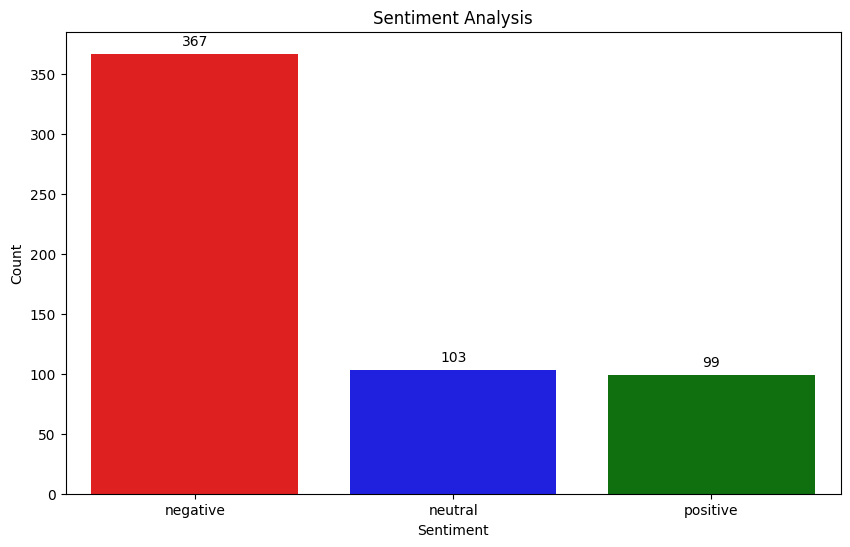

In [49]:
# sentiment analysis bar chart
# pallete set
palette_colors = {'negative': 'red', 'positive': 'green', 'neutral': 'blue'}
plt.figure(figsize=(10, 6))
ax = sns.countplot(x='sentiment', data=df, palette=palette_colors, hue='sentiment')
plt.title('Sentiment Analysis')
plt.xlabel('Sentiment')
plt.ylabel('Count')

for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', 
                xytext=(0, 9), 
                textcoords='offset points')
plt.show()

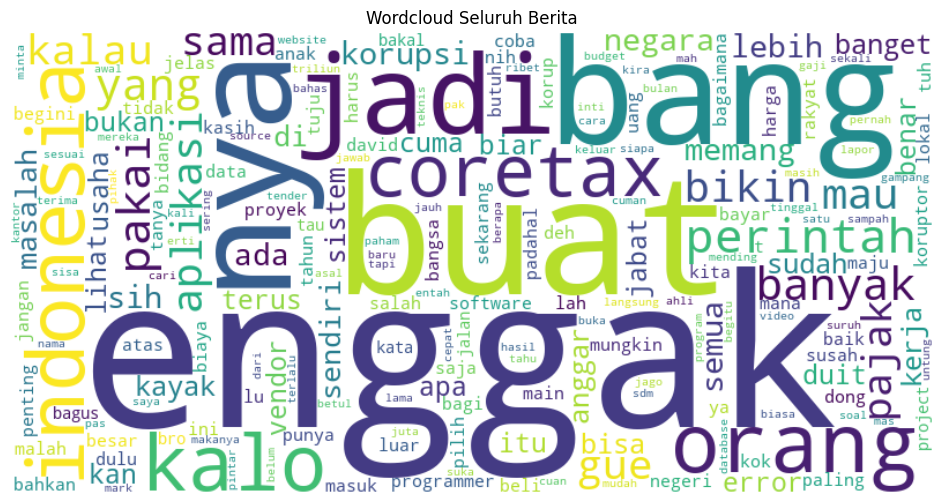

In [50]:
# Gabungkan semua teks
all_text = ' '.join(df['text_clean'].astype(str))

wc = WordCloud(width=800,
               height=400,
               background_color='white',
               collocations=False).generate(all_text)

plt.figure(figsize=(12, 6))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.title('Wordcloud Seluruh Berita')
plt.show()

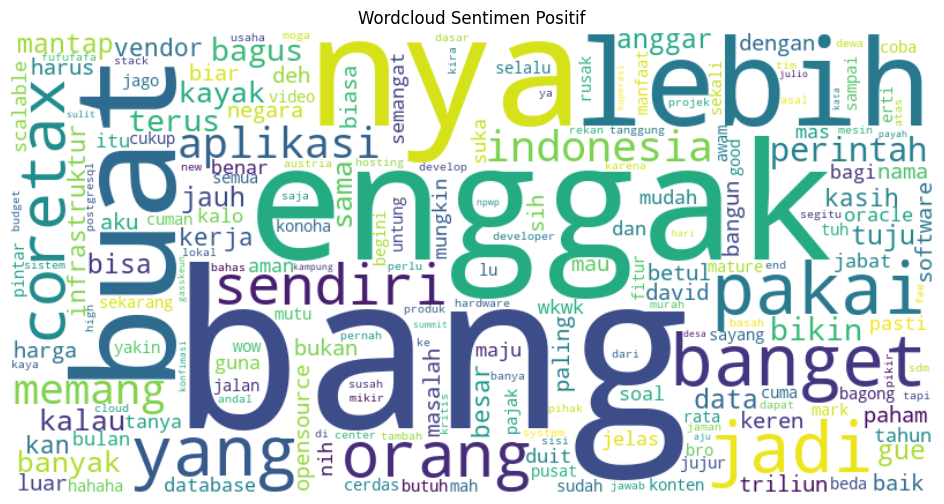

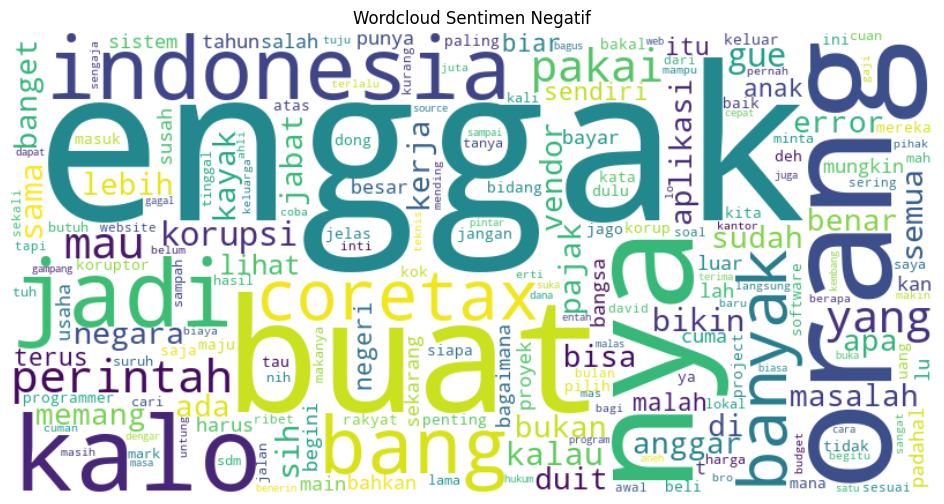

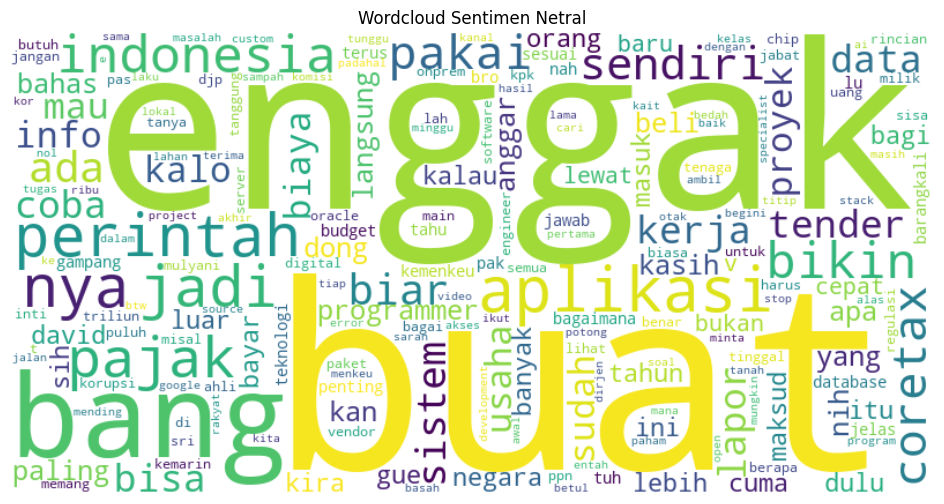

In [51]:
def plot_wordcloud_by_sentiment(label, title):
    text = ' '.join(
        df[df['sentiment'] == label]['text_clean'].astype(str)
    )
    if not text.strip():
        print(f"Tidak ada teks untuk label: {label}")
        return
    
    wc = WordCloud(width=800,
                   height=400,
                   background_color='white',
                   collocations=False).generate(text)
    
    plt.figure(figsize=(12, 6))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()

plot_wordcloud_by_sentiment('positive', 'Wordcloud Sentimen Positif')
plot_wordcloud_by_sentiment('negative', 'Wordcloud Sentimen Negatif')
plot_wordcloud_by_sentiment('neutral',  'Wordcloud Sentimen Netral')


## Training Data

In [52]:
X = df['text_clean']
y = df['sentiment']

In [53]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [54]:
cvec = CountVectorizer()
tvec = TfidfVectorizer()
hvec = HashingVectorizer()

### Naive Bayes

In [55]:
clf_nb = MultinomialNB()
model_nb = Pipeline([('vectorizer', tvec), ('classifier', clf_nb)])
model_nb.fit(x_train, y_train)
result_nb = model_nb.predict(x_test)

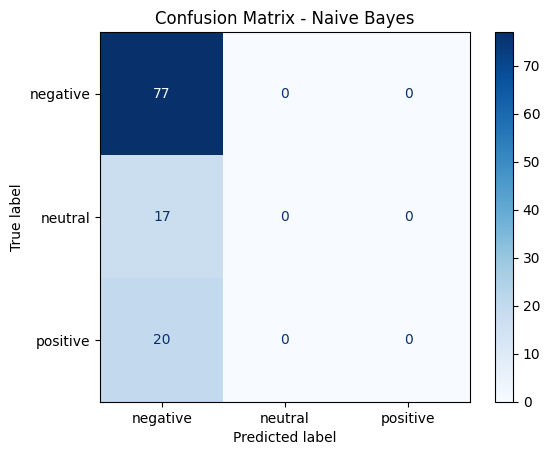

In [56]:
# confusion matrix
cm = confusion_matrix(y_test, result_nb)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model_nb.classes_)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix - Naive Bayes')
plt.show()

In [57]:
matrix = classification_report(y_test, result_nb)
print('Classification Report')
print(matrix)

Classification Report
              precision    recall  f1-score   support

    negative       0.68      1.00      0.81        77
     neutral       0.00      0.00      0.00        17
    positive       0.00      0.00      0.00        20

    accuracy                           0.68       114
   macro avg       0.23      0.33      0.27       114
weighted avg       0.46      0.68      0.54       114



f:\Dit IP\pandora-project\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
f:\Dit IP\pandora-project\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
f:\Dit IP\pandora-project\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


### SVM

In [58]:
clf_svm = SVC(kernel='rbf')
model_svm = Pipeline([('vectorizer', tvec), ('classifier', clf_svm)])
model_svm.fit(x_train, y_train)
result_svm = model_svm.predict(x_test)

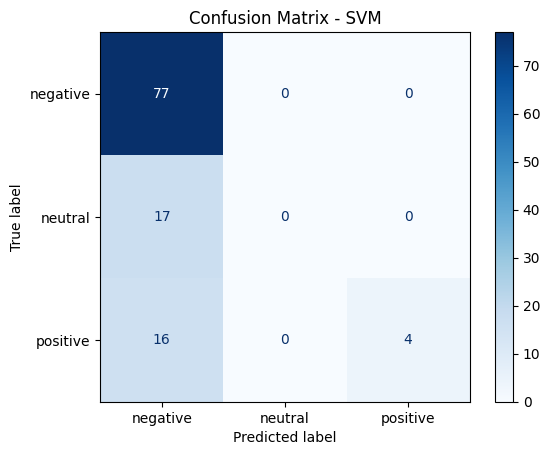

In [59]:
# confusion matrix
cm = confusion_matrix(y_test, result_svm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model_svm.classes_)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix - SVM')
plt.show()

In [60]:
matrix = classification_report(y_test, result_svm)
print('Classification Report')
print(matrix)

Classification Report
              precision    recall  f1-score   support

    negative       0.70      1.00      0.82        77
     neutral       0.00      0.00      0.00        17
    positive       1.00      0.20      0.33        20

    accuracy                           0.71       114
   macro avg       0.57      0.40      0.39       114
weighted avg       0.65      0.71      0.61       114



f:\Dit IP\pandora-project\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
f:\Dit IP\pandora-project\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
f:\Dit IP\pandora-project\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
